In [2]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rluser/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rluser/thesis_ws/src/ML_Levers_Knobs/DATA/1D_AUGM_KNOB_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)


print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)


data_dict = {
    "X_train": X_train,
    "X_test": X_test
}
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:,:,2], data[:,:,4]))
        globals()[f"{key}2"] = data[:,:,0]
        globals()[f"{key}3"] = data[:,:,5]
        globals()[f"{key}4"] = np.dstack((data[:,:,1], data[:,:,3]))

assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
print("X_train4 shape:", X_train4.shape)

import tensorflow as tf

WS_B = 2000  # Example sequence length
input_shape1 = (WS_B, 2)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 1)
input_shape4 = (WS_B, 2)
OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

    
def compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



X_data shape: (923, 2000, 9)
y_data shape: (923,)
X_data.[0] shape:  (2000, 9)
y_data.[0] max:  5.0
TOTAL DATA: 923  ||  Train = 70.0%  ||  Test = 30.0%
Dimensions of X_train: (646, 2000, 9)    ||  Dimensions of y_train: (646,)
Dimensions of X_test:  (277, 2000, 9)    ||  Dimensions of y_test:  (277,)
Shapes of the stacked arrays:
X_train1 shape: (646, 2000, 2)
X_train2 shape: (646, 2000)
X_train3 shape: (646, 2000)
X_train4 shape: (646, 2000, 2)
OUT_N: 6
DISP_LABELS: [0, 1, 2, 3, 4, 5]


2024-06-30 23:58:32.617170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 23:58:32.617538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 23:58:32.617769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 200, 64)   │      5,184 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 200, 64)   │      5,184 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 99, 128)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 99, 128)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 99, 128)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 99, 128)   │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_4_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 477,110 (1.82 MB)

 Trainable params: 477,110 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


I0000 00:00:1719784716.282912   60255 service.cc:145] XLA service 0x7cd85c018730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719784716.282942   60255 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-30 23:58:36.379226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-30 23:58:36.883906: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-30 23:58:41.366440: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3089 - loss: 1.6907

I0000 00:00:1719784725.168369   60255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3179 - loss: 1.6719

2024-06-30 23:58:49.727223: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.3201 - loss: 1.6658
Epoch 2/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3973 - loss: 1.4455
Epoch 3/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4239 - loss: 1.3637
Epoch 4/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4280 - loss: 1.2989
Epoch 5/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5259 - loss: 1.2033
Epoch 6/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4901 - loss: 1.2165
Epoch 7/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5398 - loss: 1.1235
Epoch 8/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5253 - loss: 1.1672
Epoch 9/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5959 - loss: 0.9991
Epoch 10/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6265 - loss: 0.9255
Epoch 11/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6161 - loss: 0.8772
Epoch 12/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6452 -

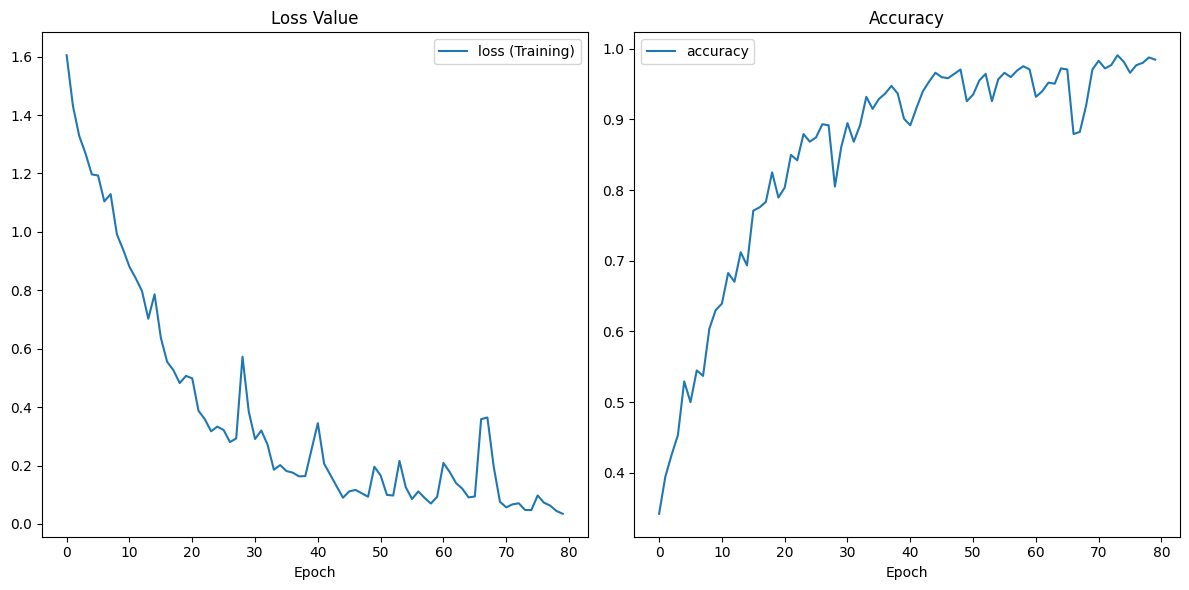

Test loss: 0.7127656936645508
Test accuracy: 0.8267148014440433
F1 Score: 0.8251634001835809
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.87      0.88        61
         1.0       0.69      0.88      0.77        72
         2.0       0.86      0.94      0.90        53
         3.0       0.92      1.00      0.96        23
         4.0       1.00      0.83      0.91        30
         5.0       0.79      0.39      0.53        38

    accuracy                           0.83       277
   macro avg       0.86      0.82      0.83       277
weighted avg       0.84      0.83      0.82       277



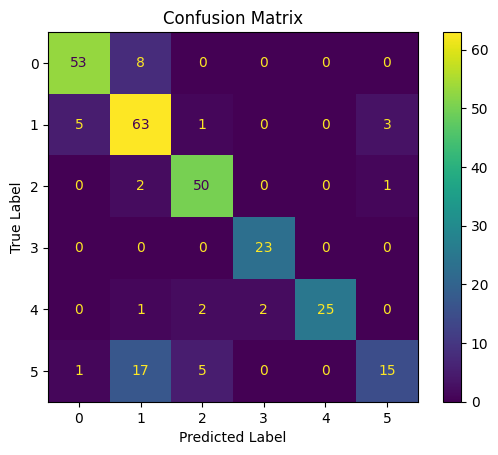

In [3]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=128, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=80, batch_size=32, patience=12, disp_labels=DISP_LABELS)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 500, 64)   │      2,624 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 500, 64)   │      1,344 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 500, 64)   │      1,344 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 500, 64)   │      2,624 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 247, 128)  │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 247, 128)  │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 247, 128)  │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 247, 128)  │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_4_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 600,502 (2.29 MB)

 Trainable params: 600,502 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


2024-06-30 23:59:23.471002: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2306 - loss: 1.7634

2024-06-30 23:59:30.908853: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.2312 - loss: 1.7601
Epoch 2/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2880 - loss: 1.6355
Epoch 3/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4329 - loss: 1.4483
Epoch 4/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4469 - loss: 1.4021
Epoch 5/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3998 - loss: 1.4483
Epoch 6/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4732 - loss: 1.2973
Epoch 7/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4862 - loss: 1.2535
Epoch 8/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5098 - loss: 1.2680
Epoch 9/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5346 - loss: 1.2174
Epoch 10/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5252 - loss: 1.1854
Epoch 11/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5360 - loss: 1.2428
Epoch 12/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4569 -

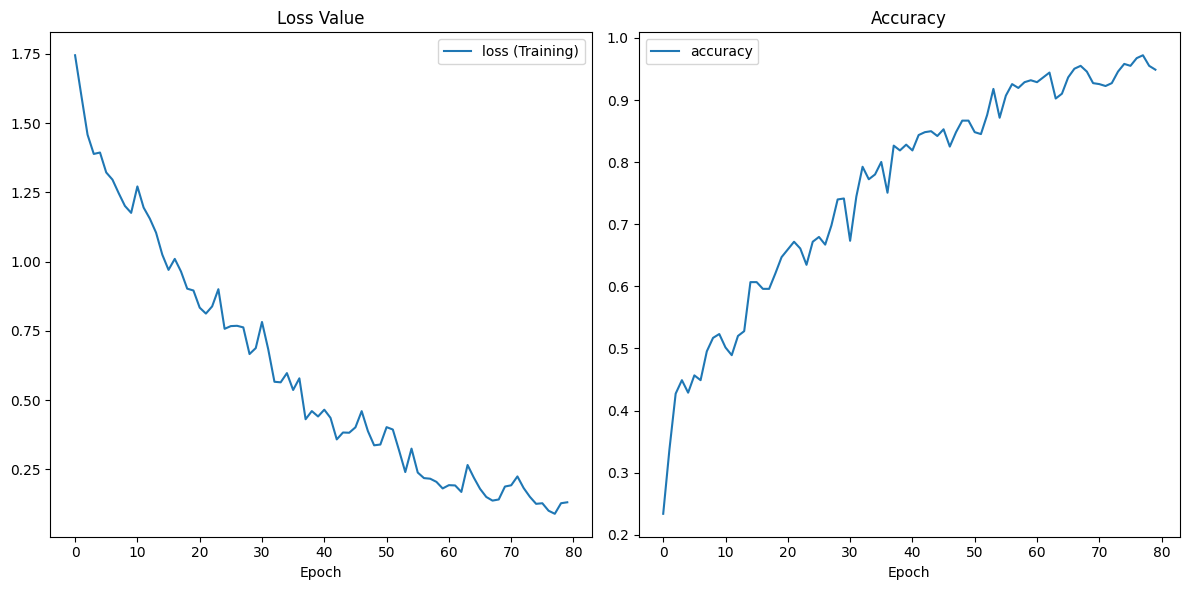

Test loss: 0.7329686284065247
Test accuracy: 0.7942238267148014
F1 Score: 0.7876042930273214
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.90      0.89        61
         1.0       0.70      0.88      0.78        72
         2.0       0.87      0.75      0.81        53
         3.0       0.79      1.00      0.88        23
         4.0       1.00      0.70      0.82        30
         5.0       0.62      0.47      0.54        38

    accuracy                           0.79       277
   macro avg       0.81      0.78      0.79       277
weighted avg       0.80      0.79      0.79       277



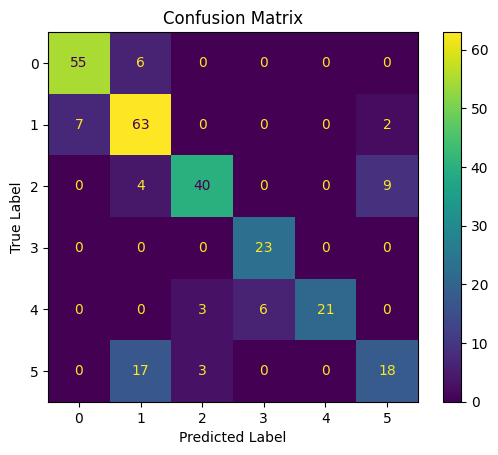

In [4]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()


X_train = [X_train1, X_train2, X_train3, X_train4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=80, batch_size=32, patience=12, disp_labels=DISP_LABELS)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 40, 64)    │     12,864 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 40, 64)    │      6,464 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 40, 64)    │      6,464 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 40, 64)    │     12,864 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_2_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_3_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_4_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 3, 256)    │          0 │ conv1d_1_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 3, 256)    │          0 │ conv1d_2_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 3, 256)    │          0 │ conv1d_3_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 3, 256)    │          0 │ conv1d_4_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_4 (Conv1D) │ (None, 2, 512)    │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_4 (Conv1D) │ (None, 2, 512)    │    262,656 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_4 (Conv1D) │ (None, 2, 512)    │    262,656 │ dropout_3_1[0][0

 Total params: 2,010,662 (7.67 MB)

 Trainable params: 2,010,662 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 416ms/step - accuracy: 0.3259 - loss: 1.6216
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5899 - loss: 1.0520
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7502 - loss: 0.7098
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8039 - loss: 0.4721
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8084 - loss: 0.4799
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8813 - loss: 0.3148
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8568 - loss: 0.3333
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8788 - loss: 0.3111
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8873 - loss: 0.2578
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9095 - loss: 0.2506
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8837 - loss: 0.2945
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9457 -

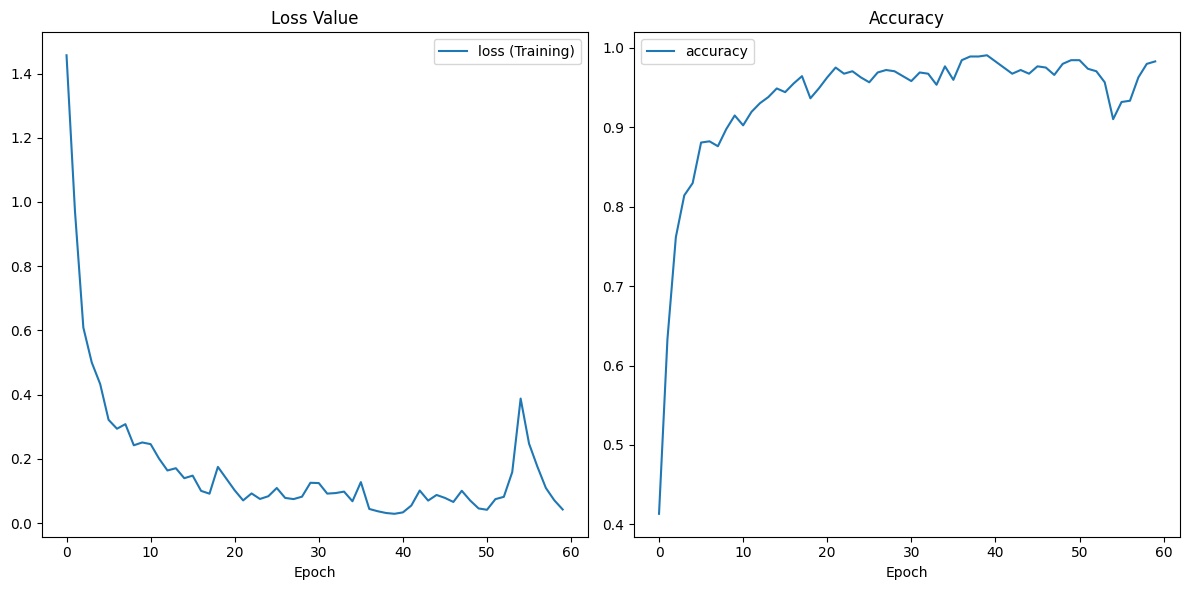

Test loss: 0.87387615442276
Test accuracy: 0.8411552346570397
F1 Score: 0.8485029249742874
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.87      0.88        61
         1.0       0.79      0.83      0.81        72
         2.0       0.82      0.87      0.84        53
         3.0       0.92      1.00      0.96        23
         4.0       0.90      0.93      0.92        30
         5.0       0.77      0.61      0.68        38

    accuracy                           0.84       277
   macro avg       0.85      0.85      0.85       277
weighted avg       0.84      0.84      0.84       277



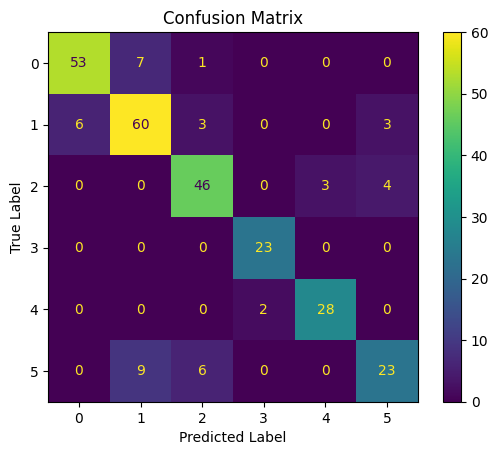

In [5]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=100, strides=50, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=128, kernel_size=8, strides=4, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=512, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_4')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(32, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=60, batch_size=32, patience=12, disp_labels=DISP_LABELS)